In [1]:
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import os
import pytpc
from random import shuffle

# NOT RELEVENT to current state of analysis
# Walk through of old method of hit detection and plotting

In [2]:
def _l(a):
    return 0 if a == 0 else math.log10(a)

In [94]:
THRESHOLD = 50
NUMBEROFPADS = 10240

In [201]:
#def real_unlabeled_events(projection, save_path, prefix):
#print('Processing data...')
data = []

In [141]:
xyzsList = []

In [142]:
events = pytpc.HDFDataFile('corrected_run_0210.h5', 'r')
for event in events:
    # Get pytpc xyzs
    xyzs = event.xyzs(peaks_only=True, return_pads=True,
        baseline_correction=False, cg_times=False)

    xyzsList.append(xyzs)

In [202]:
event1xyzs = xyzsList[63] 

In [203]:
eventTrace = np.ndarray(10240, dtype=object)
# Get the events trace across each pad
with h5py.File('corrected_run_0210.h5', 'r') as f:
    dset = f['get/64']
    trace = dset[:,10:510]
    TRACELENGTH = 500
    for i in range(NUMBEROFPADS):            
        y = np.zeros(TRACELENGTH)        
        padNumber = dset[i,4]
        currentPad = trace[i]
        for j in range(TRACELENGTH):
            y[j] = currentPad[j]
        eventTrace[padNumber] = y

In [219]:
# Find the correct peak charge value for each trace
hitPeaks = []
for i in range(NUMBEROFPADS):
    trace = eventTrace[i]
    traceMax = np.amax(trace)
    traceMin = np.amin(trace)
    peakTimeIndex = []
    if(traceMax - traceMin > THRESHOLD):
        for j in range(len(trace)):
            if(np.max(trace) == trace[j]):
                peakTimeIndex.append(j+0.0)
        for k in range(len(peakTimeIndex)):
            peakTime = peakTimeIndex[k]
            hitPeaks.append([peakTime, traceMax, i + 0.0])
                            #  time     charge   padnumber
np.asarray(hitPeaks)

HITPEAKSLENGTH = len(hitPeaks)

In [221]:
# Merge pytpc xyzs array with correct charge values
plotPoints = np.zeros(shape=(HITPEAKSLENGTH,4))
for i in range(HITPEAKSLENGTH):
    hitPeaksPadNum = hitPeaks[i][2]
    for j in range(NUMBEROFPADS):
        xyzsPadNum = event1xyzs[j][4]
        if(hitPeaksPadNum == xyzsPadNum):
            plotPoints[i][0] = event1xyzs[j][0] #xyzs[j][0]     #x
            plotPoints[i][1] = event1xyzs[j][1] #xyzs[j][1]    #y
            plotPoints[i][2] = hitPeaks[i][0]   #time
            plotPoints[i][3] = hitPeaks[i][1]   #charge

data.append(plotPoints)

In [207]:
print(data)

[array([[-125.15999631,    7.05056055,  415.        ,  502.        ],
       [-122.70587873,    5.70140844,  415.        ,  322.        ],
       [-120.25176116,    7.05056055,  416.        ,  475.        ],
       ...,
       [ -58.89882179, -266.40832983,  385.        , 1424.        ],
       [ -53.99058664, -269.37756738,  384.        ,  372.        ],
       [ -53.99058664, -269.37756738,  386.        ,  372.        ]])]


In [208]:
# Take the log of charge data
log = np.vectorize(_l)

In [209]:
print(data[0][0][3])
print(data[0][1][3])
print(data[0][2][3])
print(data[0][3][3])

502.0
322.0
475.0
431.0


In [210]:
for event in data:
    event[:,3] = log(event[:,3])

In [211]:
print(data[0][0][3])
print(data[0][1][3])
print(data[0][2][3])
print(data[0][3][3])

2.7007037171450192
2.507855871695831
2.6766936096248664
2.6344772701607315


In [212]:
# Normalize
max_charge = np.array(list(map(lambda x: x[:, 3].max(),data))).max()

In [213]:
print(max_charge)

3.6011905326153335


In [214]:
for e in data:
    for point in e:
        point[3] = point[3] / max_charge

In [215]:
print(data[0][0][3])
print(data[0][1][3])
print(data[0][2][3])
print(data[0][3][3])

0.7499474667294698
0.6963963303198296
0.7432801973076778
0.731557313144291


In [216]:
#print('Making images...')
# Make numpy set
images = np.empty((len(data), 128, 128, 3), dtype=np.uint8)

In [217]:
projection = 'xy'
#for i, event in enumerate(data):
#    e = event
e = data[0]
if projection == 'zy':
    x = e[:, 2] #actually z (time)
    y = e[:, 1]
    charge = e[:, 3]
elif projection == 'xy':
    x = e[:, 0]
    y = e[:, 1]
    charge = e[:, 3]
else:
    raise ValueError('Invalid projection value.')

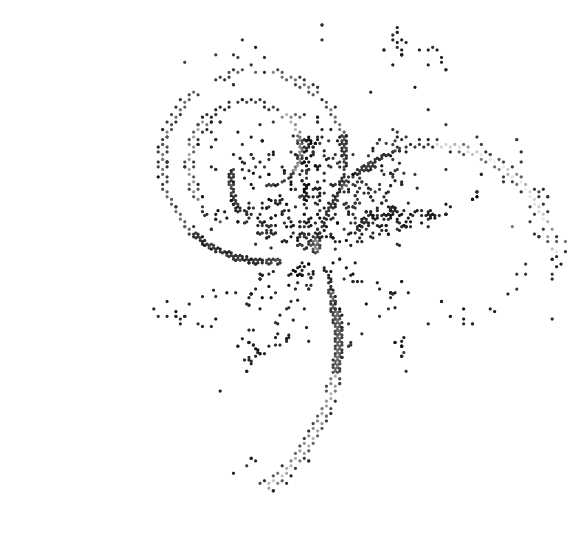

In [218]:
fig = plt.figure(figsize=(5, 5), dpi=128)
if projection == 'zy':
    plt.xlim(0.0, 512)
if projection == 'xy':
    plt.xlim(-275.0, 275.0)
plt.ylim((-275.0, 275.0))
plt.axis('off')
plt.scatter(x, y, s=0.6, c=charge, cmap='gray')
plt.show()